Hello this is my code for prediciting stokcs using LSTM Neural Networks in Python

The data set can be found using Yahoo finance

For this particular data set i am using NVDA historical data

Link:  https://uk.finance.yahoo.com/quote/NVDA/history?p=NVDA


1. importing Pandas and reading the CSV bellow

In [14]:
import pandas as pd
df = pd.read_csv('NVDA.csv')
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376319,271468800
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415743,51048000
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383487,34320000
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382293,24436800
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381098,22752000
...,...,...,...,...,...,...,...
6175,2023-08-08,448.529999,452.420013,440.559998,446.640015,446.640015,35384300
6176,2023-08-09,442.739990,443.119995,421.339996,425.540009,425.540009,58644900
6177,2023-08-10,421.600006,435.739990,418.350006,423.880005,423.880005,49270500
6178,2023-08-11,417.510010,420.179993,406.390015,408.549988,408.549988,53200900


2. Shorting the dataset columns to only show the date and closing price


In [15]:
df = df[['Date', 'Close']]
df


,Date,Close
0,1999-01-22,0.410156
1,1999-01-25,0.453125
2,1999-01-26,0.417969
3,1999-01-27,0.416667
4,1999-01-28,0.415365
...,...,...
6175,2023-08-08,446.640015
6176,2023-08-09,425.540009
6177,2023-08-10,423.880005
6178,2023-08-11,408.549988


3. The datatype in CSV is a string and not a date so its important to covert the strings to a date for later and changing the index column to date

Function code


In [16]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object


datetime.datetime(1986, 3, 19, 0, 0)

Applying the Function to the dataset

In [17]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-17-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1999-01-22
1      1999-01-25
2      1999-01-26
3      1999-01-27
4      1999-01-28
          ...    
6175   2023-08-08
6176   2023-08-09
6177   2023-08-10
6178   2023-08-11
6179   2023-08-14
Name: Date, Length: 6180, dtype: datetime64[ns]

Making Date the index column

In [18]:
df.index = df.pop('Date')
df

,Close
Date,
1999-01-22,0.410156
1999-01-25,0.453125
1999-01-26,0.417969
1999-01-27,0.416667
1999-01-28,0.415365
...,...
2023-08-08,446.640015
2023-08-09,425.540009
2023-08-10,423.880005


4. Importing Matplotlib for visuals


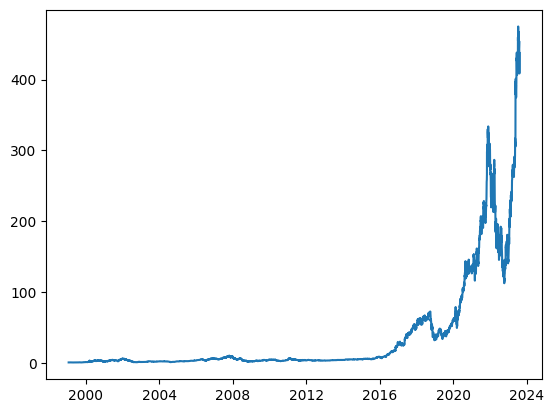

In [19]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])


5. Because we are using LSTM model. it need to be converted to a supervised learning problem

This window function finds the prices 3 days before that. target 1,2,3 of each individual date. this is essentially a regression problem. and outputs a "target" from the 3 prices which will feed into the tensorflow model

In [20]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: 'YEAR-MONTH-DATE'
windowed_df = df_to_windowed_df(df,
                                '2000-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2000-03-25,1.976563,1.990885,2.026042,1.941406
1,2000-03-28,2.026042,1.941406,1.813802,1.678385
2,2000-03-29,1.941406,1.813802,1.678385,1.567708
3,2000-03-30,1.813802,1.678385,1.567708,1.558594
4,2000-03-31,1.678385,1.567708,1.558594,1.760091
...,...,...,...,...,...
5529,2022-03-17,213.300003,229.729996,244.960007,247.660004
5530,2022-03-18,229.729996,244.960007,247.660004,264.529999
5531,2022-03-21,244.960007,247.660004,264.529999,267.339996
5532,2022-03-22,247.660004,264.529999,267.339996,265.239990


takes the matrix above (target 1,2,3) and outputs "target"

In [21]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((5534,), (5534, 3, 1), (5534,))

6. Spliting the data into 3 partitions: Training, Validation, Test

Training will train the model

Validation will help train the model

Test will really be used to evaluate the model


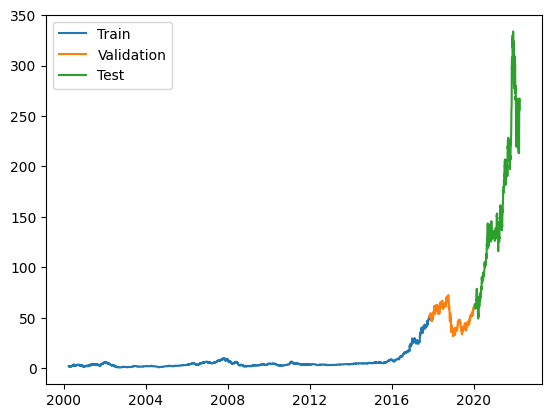

In [22]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

7. Building a sequential model from tensorflow
Adam is the optimises the learning rate

LSTM using 64 nodes relatively abatrary but 64 is not too big but not too small
More nodes means more heavy duty

THe learning rate can be changed

the Epochs means 100 runs through dataset

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
139/139 [==============================] - 5s 10ms/step - loss: 37.6443 - mean_absolute_error: 2.4315 - val_loss: 255.2671 - val_mean_absolute_error: 13.1293
Epoch 2/100
139/139 [==============================] - 1s 6ms/step - loss: 0.2344 - mean_absolute_error: 0.1954 - val_loss: 89.2643 - val_mean_absolute_error: 6.8945
Epoch 3/100
139/139 [==============================] - 1s 6ms/step - loss: 0.1132 - mean_absolute_error: 0.1687 - val_loss: 66.6912 - val_mean_absolute_error: 5.8845
Epoch 4/100
139/139 [==============================] - 1s 6ms/step - loss: 0.1269 - mean_absolute_error: 0.1858 - val_loss: 58.2177 - val_mean_absolute_error: 5.3946
Epoch 5/100
139/139 [==============================] - 1s 6ms/step - loss: 0.1059 - mean_absolute_error: 0.1677 - val_loss: 53.2067 - val_mean_absolute_error: 5.0991
Epoch 6/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0983 - mean_absolute_error: 0.1635 - val_loss: 52.5210 - val_mean_absolute_error: 5.2048


Orange is what really happened

Blue is what the model predicts

Training model Predictions

139/139 [==============================] - 1s 3ms/step


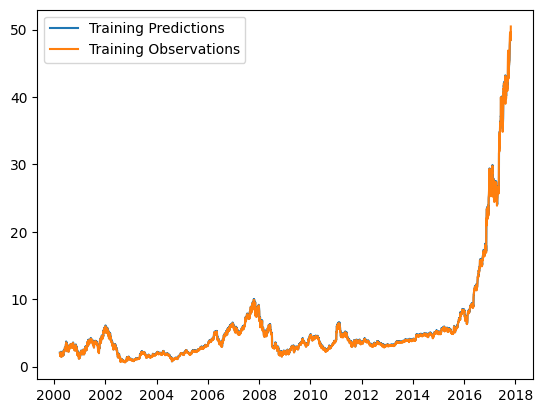

In [24]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

Validation Prediction

18/18 [==============================] - 0s 4ms/step


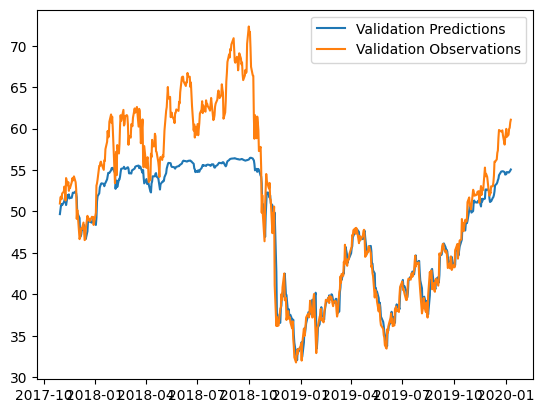

In [25]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

Testing Prediction

18/18 [==============================] - 0s 3ms/step


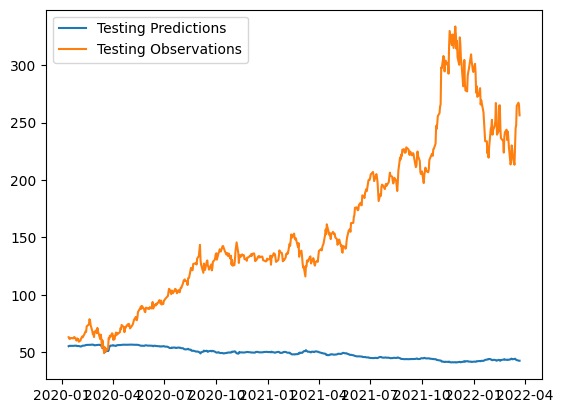

In [29]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

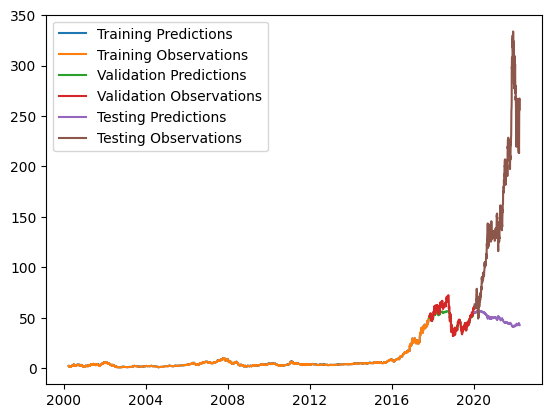

In [30]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [33]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])
for target_date in recursive_dates:

  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 23ms/step


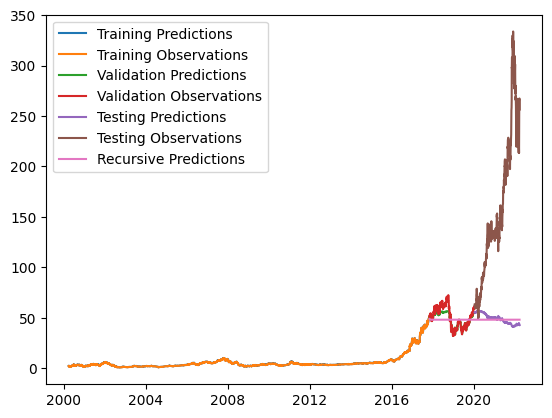

In [34]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])